<a href="https://colab.research.google.com/github/sanme10/GeoAI-Feature-Extraction/blob/main/Building_Detection_using_Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## 2. Data Organization


In [ ]:
import os
import random
import rasterio
from rasterio.windows import Window
from rasterio.features import rasterize
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, box

# ==============================
# PATHS
# ==============================
satellite_fp = r"D:\Building_Detection\Image\Image_AOI.tif"
buildings_fp = r"D:\Building_Detection\Label\Building.shp"
base_output = r'D:\Sandeep\BuildingDetection'

img_dir = os.path.join(base_output, "images")
lbl_dir = os.path.join(base_output, "labels")

os.makedirs(img_dir, exist_ok=True)
os.makedirs(lbl_dir, exist_ok=True)

PATCH_SIZE = 256
HALF = PATCH_SIZE // 2
BACKGROUND_RATIO = 0.20

# ==============================
# LOAD VECTOR DATA
# ==============================
gdf = gpd.read_file(buildings_fp)

with rasterio.open(satellite_fp) as src:

    # Reproject vector to raster CRS
    gdf = gdf.to_crs(src.crs)

    # ---------- METADATA ----------
    img_meta = src.meta.copy()

    lbl_meta = src.meta.copy()
    lbl_meta.update(
        {
            "count": 1,
            "dtype": "uint8",
            # Removed "nodata": 0 to ensure 0 values are not masked out
        }
    )

    # ---------- UTILITY ----------
    def is_window_valid(w):
        return (
            w.col_off >= 0
            and w.row_off >= 0
            and w.col_off + w.width <= src.width
            and w.row_off + w.height <= src.height
        )

    def geometry_to_yolo_bbox(geometry, patch_size, transform_matrix):
        """
        Converts a shapely geometry to YOLO bounding box format (class_id, x_center, y_center, width, height)
        relative to a patch, with coordinates normalized [0, 1].
        """
        if geometry.is_empty:
            return None

        minx, miny, maxx, maxy = geometry.bounds

        # Convert global coordinates to pixel coordinates relative to the patch's top-left
        # rasterio's transform maps (col, row) to (x, y) starting from top-left
        # Inverse transform maps (x, y) to (col, row)
        x_min_pix, y_max_pix = ~transform_matrix * (minx, miny)
        x_max_pix, y_min_pix = ~transform_matrix * (maxx, maxy)

        # Ensure correct min/max for pixel coordinates relative to the patch (top-left is 0,0)
        # rasterio's Y-axis increases downwards, so miny (global) corresponds to max_row (pixel)
        # and maxy (global) corresponds to min_row (pixel)
        # We need to consider the patch origin (0,0) as the top-left of the window

        # Clamp pixel coordinates to patch boundaries [0, PATCH_SIZE - 1]
        x_min_pix = np.clip(x_min_pix, 0, patch_size - 1)
        y_min_pix = np.clip(y_min_pix, 0, patch_size - 1)
        x_max_pix = np.clip(x_max_pix, 0, patch_size - 1)
        y_max_pix = np.clip(y_max_pix, 0, patch_size - 1)

        # Calculate center, width, height in pixel coordinates
        width_pix = x_max_pix - x_min_pix
        height_pix = y_max_pix - y_min_pix

        # Handle cases where width or height might be zero or negative due to clamping/tiny geometries
        if width_pix <= 0 or height_pix <= 0:
            return None

        center_x_pix = x_min_pix + width_pix / 2
        center_y_pix = y_min_pix + height_pix / 2

        # Normalize to [0, 1]
        x_center_norm = center_x_pix / patch_size
        y_center_norm = center_y_pix / patch_size  # Corrected line
        width_norm = width_pix / patch_size
        height_norm = height_pix / patch_size

        # YOLO format: class_id x_center y_center width height
        # Assuming class 0 for buildings
        return f"0 {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}"

    saved_count = 0

    # ==============================
    # 1″ COTTON PATCHES
    # ==============================
    for idx, row in gdf.iterrows():

        fid = row['fid'] if 'fid' in row else idx
        centroid = row.geometry.centroid

        # Map → pixel
        col, row_pix = ~src.transform * (centroid.x, centroid.y)
        col, row_pix = int(col), int(row_pix)

        window = Window(col - HALF, row_pix - HALF, PATCH_SIZE, PATCH_SIZE)

        if not is_window_valid(window):
            continue

        # ---------- IMAGE ----------
        # Read only the first 3 bands (assuming RGB) to match YOLO model input
        image = src.read([1, 2, 3], window=window)
        win_transform = src.window_transform(window)

        img_meta.update(
            {"height": PATCH_SIZE, "width": PATCH_SIZE, "transform": win_transform, "count": 3}
        )

        img_fp = os.path.join(img_dir, f"building_{fid}.tif")
        with rasterio.open(img_fp, "w", **img_meta) as dst:
            dst.write(image)

        # ---------- LABEL (ZERO FIRST) ----------
        # Existing rasterization logic will be replaced or removed after YOLO integration
        # label = np.zeros((PATCH_SIZE, PATCH_SIZE), dtype=np.uint8)

        window_bounds = rasterio.windows.bounds(window, src.transform)
        window_geom = box(*window_bounds)

        intersecting = gdf[gdf.intersects(window_geom)]

        if not intersecting.empty:
            # New logic to generate YOLO bounding box annotations
            yolo_annotations_current_patch = []
            for geom in intersecting.geometry:
                yolo_bbox = geometry_to_yolo_bbox(geom, PATCH_SIZE, win_transform)
                if yolo_bbox:
                    yolo_annotations_current_patch.append(yolo_bbox)

            # Save YOLO annotations to a text file
            if yolo_annotations_current_patch:
                lbl_fp_txt = os.path.join(lbl_dir, f"building_{fid}.txt")
                with open(lbl_fp_txt, "w") as f:
                    for bbox_str in yolo_annotations_current_patch:
                        f.write(bbox_str + "\n")

            # The rasterization part is no longer needed for YOLO annotations
            # burned = rasterize(
            #     [(geom, 1) for geom in intersecting.geometry],
            #     out_shape=(PATCH_SIZE, PATCH_SIZE),
            #     transform=win_transform,
            #     fill=0,
            #     dtype="uint8",
            # )
            # label[burned == 1] = 1

        # The raster label saving is no longer needed for YOLO annotations
        # lbl_meta.update(
        #     {"height": PATCH_SIZE, "width": PATCH_SIZE, "transform": win_transform}
        # )
        # lbl_fp = os.path.join(lbl_dir, f"building_{fid}.tif")
        # with rasterio.open(lbl_fp, "w", **lbl_meta) as dst:
        #     dst.write(label, 1)

        saved_count += 1 # This count now refers to image-annotation pairs

    print(f"Saved {saved_count} building image-annotation pairs (YOLO format)")

    # ==============================
    # 2″ BACKGROUND PATCHES (20%)
    # ==============================
    num_background = int(saved_count * BACKGROUND_RATIO)

    bg_count = 0
    attempts = 0

    while bg_count < num_background and attempts < num_background * 10:

        attempts += 1

        col = random.randint(HALF, src.width - HALF)
        row_pix = random.randint(HALF, src.height - HALF)

        x, y = src.transform * (col, row_pix)
        point = Point(x, y)

        # Skip if centroid is inside any building
        # This check is less strict than the window intersection check below
        if gdf.contains(point).any():
            continue

        window = Window(col - HALF, row_pix - HALF, PATCH_SIZE, PATCH_SIZE)

        if not is_window_valid(window):
            continue

        # Check if the candidate background window intersects ANY building
        window_bounds = rasterio.windows.bounds(window, src.transform)
        window_geom = box(*window_bounds)
        intersecting_buildings = gdf[gdf.intersects(window_geom)]
        if not intersecting_buildings.empty:
            continue  # This patch contains buildings, so it's not a true background patch

        # ---------- IMAGE ----------
        # Read only the first 3 bands (assuming RGB) for consistency with building patches
        image = src.read([1, 2, 3], window=window)

        # NEW: Skip if the image is completely black (no data)
        if np.all(image == 0):
            continue

        win_transform = src.window_transform(window)

        img_meta.update(
            {"height": PATCH_SIZE, "width": PATCH_SIZE, "transform": win_transform, "count": 3}
        )

        img_fp = os.path.join(img_dir, f"background_{bg_count}.tif")
        with rasterio.open(img_fp, "w", **img_meta) as dst:
            dst.write(image)

        # ---------- LABEL (ALL ZERO) ----------
        # For background images, the label file will be empty or contain nothing, signifying no objects
        lbl_fp_txt = os.path.join(lbl_dir, f"background_{bg_count}.txt")
        with open(lbl_fp_txt, "w") as f:
            pass # Create an empty file

        # The raster label saving is no longer needed
        # label = np.zeros((PATCH_SIZE, PATCH_SIZE), dtype=np.uint8)

        # lbl_meta.update(
        #     {"height": PATCH_SIZE, "width": PATCH_SIZE, "transform": win_transform}
        # )

        # lbl_fp = os.path.join(lbl_dir, f"background_{bg_count}.tif")
        # with rasterio.open(lbl_fp, "w", **lbl_meta) as dst:
        #     dst.write(label, 1)

        bg_count += 1

    print(f"Saved {bg_count} background image-annotation pairs (empty YOLO files)")

ModuleNotFoundError: No module named 'rasterio'

## 2. Data Organization

To prepare the dataset for YOLOv8 training, we need to organize the images and labels into a specific directory structure. This typically involves separating data into `train`, `val`, and optionally `test` splits, each containing an `images` and `labels` subdirectory.

### Subtask: Create Data Splits and Directory Structure

#### Instructions
1.  Determine the split ratios for `train`, `val`, and `test` (e.g., 80% train, 10% val, 10% test).
2.  Create the following directory structure within your `base_output` directory:

    ```
    base_output/
    ├── images/       (Already contains all .tif images)
    └── labels/       (Already contains all .txt YOLO labels)
    └── dataset/
        ├── train/
        │   ├── images/
        │   └── labels/
        ├── val/
        │   ├── images/
        │   └── labels/
        └── test/ (Optional, but good practice)
            ├── images/
            └── labels/
    ```

3.  Iterate through all image and label files in `img_dir` and `lbl_dir`.
4.  Randomly assign each image-label pair to either the `train`, `val`, or `test` split based on the defined ratios.
5.  Move (or copy) the image files (`.tif`) to their respective `dataset/{split}/images/` directories.
6.  Move (or copy) the label files (`.txt`) to their respective `dataset/{split}/labels/` directories.

In [ ]:
import os
import shutil
import random

# Define split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Ensure ratios sum to 1
if not (train_ratio + val_ratio + test_ratio == 1.0):
    raise ValueError("Train, validation, and test ratios must sum to 1.0")

# Define base directories (assuming img_dir and lbl_dir are already defined from initial setup)
dataset_base_dir = os.path.join(base_output, "dataset")

# Create main dataset directory and subdirectories for train, val, test
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(dataset_base_dir, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(dataset_base_dir, split, "labels"), exist_ok=True)

# Get a list of all image and label file pairs
all_files = []
for img_filename in os.listdir(img_dir):
    if img_filename.endswith('.tif'):
        base_name = os.path.splitext(img_filename)[0]
        lbl_filename = base_name + '.txt'
        img_path = os.path.join(img_dir, img_filename)
        lbl_path = os.path.join(lbl_dir, lbl_filename)

        if os.path.exists(lbl_path): # Ensure a corresponding label file exists
            all_files.append((img_path, lbl_path, base_name))
        else:
            print(f"Warning: No label file found for image {img_filename}. Skipping.")

random.shuffle(all_files)

# Calculate split sizes
total_files = len(all_files)
train_size = int(total_files * train_ratio)
val_size = int(total_files * val_ratio)
# Test size will be the remainder to ensure all files are included
test_size = total_files - train_size - val_size

# Split the files
train_files = all_files[:train_size]
val_files = all_files[train_size:train_size + val_size]
test_files = all_files[train_size + val_size:]

splits = {"train": train_files, "val": val_files, "test": test_files}

# Move files to their respective directories
for split_name, file_list in splits.items():
    print(f"Moving {len(file_list)} files to {split_name}...")
    for img_path, lbl_path, base_name in file_list:
        # Move image
        dest_img_path = os.path.join(dataset_base_dir, split_name, "images", os.path.basename(img_path))
        shutil.move(img_path, dest_img_path)

        # Move label
        dest_lbl_path = os.path.join(dataset_base_dir, split_name, "labels", os.path.basename(lbl_path))
        shutil.move(lbl_path, dest_lbl_path)

print("Data organization complete!")
print(f"Train images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")
print(f"Test images: {len(test_files)}")

Moving 1398 files to train...
Moving 174 files to val...
Moving 176 files to test...
Data organization complete!
Train images: 1398
Validation images: 174
Test images: 176


## 3. Configuration File Generation

To train a YOLOv8 model, we need a configuration file (typically in YAML format) that tells the model where to find the data, what the class names are, and how many classes there are. This file acts as a manifest for our dataset.

### Subtask: Create `dataset.yaml` for YOLOv8

#### Instructions
1.  Create a new file named `dataset.yaml` in the `base_output` directory (e.g., `D:\Sandeep\BuildingDetection\dataset.yaml`).
2.  Populate this file with the following structure, replacing placeholders with your actual paths and class information:

    ```yaml
    # dataset.yaml

    # Path to the dataset root directory
    path: {base_output}/dataset # Adjust this path relative to where you run your training script or provide an absolute path

    # Train, validation, and test image directories
    train: train/images  # train images (relative to 'path')
    val: val/images      # val images (relative to 'path')
    test: test/images    # test images (optional) (relative to 'path')

    # Number of classes
    nc: 1

    # Class names
    names:
      0: building
    ```

3.  Ensure the `path` variable is correctly set. If your training script is run from the `base_output` directory, `../dataset` would be appropriate for the `dataset` folder created inside `base_output`. If running from another location, adjust accordingly. You can also use an absolute path.
4.  Confirm `nc` matches the number of unique classes in your dataset (which is 1 for 'building').
5.  Verify the `names` list accurately reflects your class names and their corresponding `class_id`.

In [ ]:
import os

dataset_yaml_content = f"""
# dataset.yaml

# Path to the dataset root directory
path: {base_output}/dataset # Adjust this path relative to where you run your training script or provide an absolute path

# Train, validation, and test image directories
train: train/images  # train images (relative to 'path')
val: val/images      # val images (relative to 'path')
test: test/images    # test images (optional) (relative to 'path')

# Number of classes
nc: 1

# Class names
names:
  0: building
"""

dataset_yaml_path = os.path.join(base_output, "dataset.yaml")

with open(dataset_yaml_path, "w") as f:
    f.write(dataset_yaml_content)

print(f"Created dataset.yaml at: {dataset_yaml_path}")
print("Content:")
print(dataset_yaml_content)

Created dataset.yaml at: D:\Sandeep\BuildingDetection\dataset.yaml
Content:

# dataset.yaml

# Path to the dataset root directory
path: D:\Sandeep\BuildingDetection/dataset # Adjust this path relative to where you run your training script or provide an absolute path

# Train, validation, and test image directories
train: train/images  # train images (relative to 'path')
val: val/images      # val images (relative to 'path')
test: test/images    # test images (optional) (relative to 'path')

# Number of classes
nc: 1

# Class names
names:
  0: building



## 4. Model Training

With the dataset organized and the configuration file (`dataset.yaml`) ready, we can now train a YOLOv8 model. We'll use the `ultralytics` library, which simplifies the training process. We will load a pre-trained YOLOv8 model and fine-tune it on our custom building detection dataset.

### Subtask: Train YOLOv8 Model

#### Instructions
1.  Import the `YOLO` class from the `ultralytics` library.
2.  Load a pre-trained YOLOv8 model (e.g., `yolov8n.pt` for nano version, `yolov8s.pt` for small, etc.). You can choose a model size based on your computational resources and desired performance.
3.  Initiate the training process using the `model.train()` method.
    *   Specify the `data` argument to point to your `dataset.yaml` file.
    *   Set the `epochs` (number of training iterations) to a suitable value (e.g., 50-100 for initial testing).
    *   Define `imgsz` (image size) which should match the `PATCH_SIZE` used during data generation (e.g., 256).
    *   Optionally, specify `batch` size, `device` (e.g., `0` for GPU, `cpu` for CPU), and `name` for your training run.

**Example:**

```python
from ultralytics import YOLO

# Load a pre-trained YOLOv8n model
model = YOLO('yolov8n.pt')  # 'n' for nano, 's' for small, 'm' for medium, 'l' for large, 'x' for xlarge

# Train the model
results = model.train(data=dataset_yaml_path, epochs=50, imgsz=PATCH_SIZE, batch=16, name='yolov8_buildings')
```

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8n model. Other options include 'yolov8s.pt', 'yolov8m.pt', etc.
# You can choose based on your computational resources and desired performance.
model = YOLO('yolov8n.pt')

# Train the model
# 'data' points to your dataset.yaml file
# 'epochs' determines the number of training iterations
# 'imgsz' should match the PATCH_SIZE used during data generation
# 'batch' specifies the batch size (adjust based on your GPU memory)
# 'name' is an optional name for your training run, which creates a directory for results
results = model.train(data=dataset_yaml_path, epochs=50, imgsz=PATCH_SIZE, batch=16, name='yolov8_buildings')


Ultralytics 8.4.14  Python-3.10.19 torch-2.10.0+cpu CPU (AMD Ryzen 5 5600H with Radeon Graphics)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Sandeep\BuildingDetection\dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8_buildings2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap

In [ ]:
from ultralytics import YOLO

# 1. Load your best trained model
model = YOLO(r'C:\Users\Nitro 5\runs\detect\yolov8_buildings2\weights\best.pt')

# 2. Run validation on the test set
# This will use the 'test' path from your dataset.yaml
metrics = model.val(split='test')

# 3. Print the key results
print(f"Test mAP50: {metrics.box.map50:.3f}")
print(f"Test mAP50-95: {metrics.box.map:.3f}")

Ultralytics 8.4.14  Python-3.10.19 torch-2.10.0+cpu CPU (AMD Ryzen 5 5600H with Radeon Graphics)
Model summary (fused): 73 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.20.0 ms, read: 16.43.2 MB/s, size: 192.5 KB)
val: Scanning D:\Sandeep\BuildingDetection\dataset\test\labels... 176 images, 30 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 176/176 290.5it/s 0.6s
val: New cache created: D:\Sandeep\BuildingDetection\dataset\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 2.6it/s 4.3s
                   all        176       1767      0.953      0.917      0.957      0.797
Speed: 0.4ms preprocess, 16.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to C:\Users\Nitro 5\runs\detect\val
Test mAP50: 0.957
Test mAP50-95: 0.797


Visualizing 5 random images from the test set...


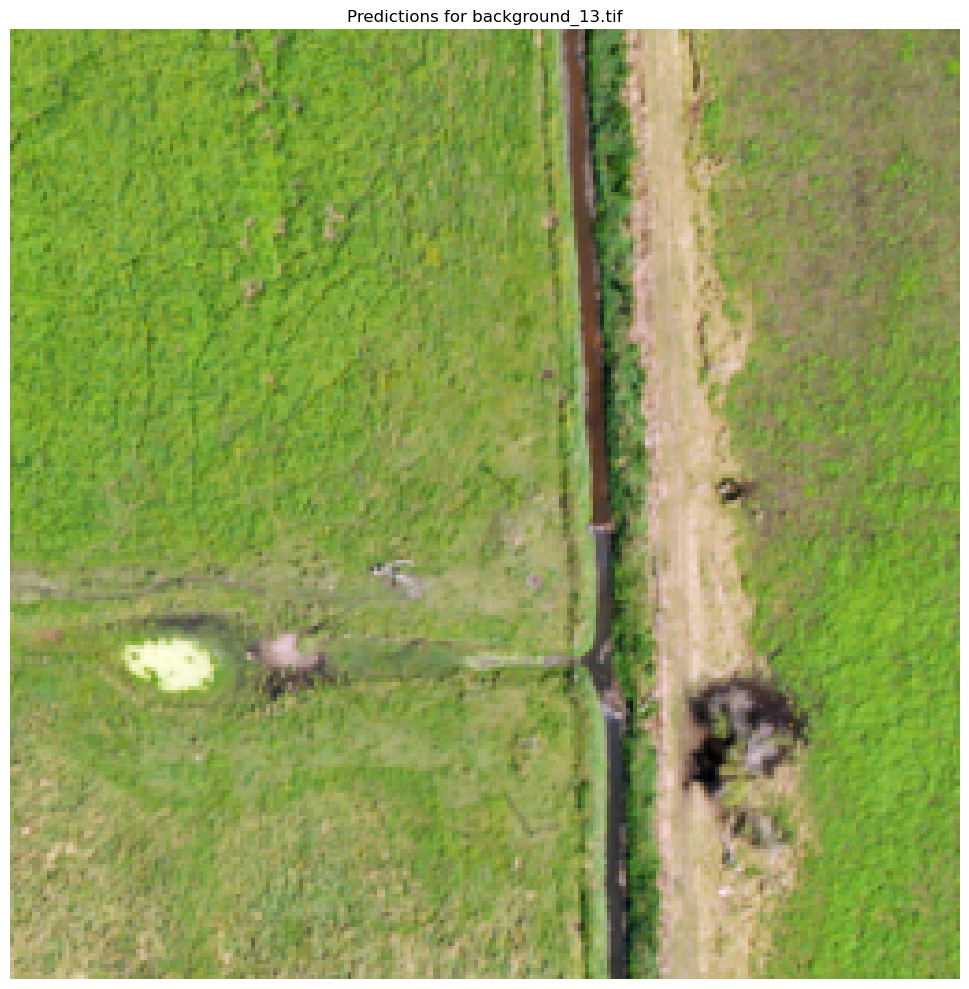

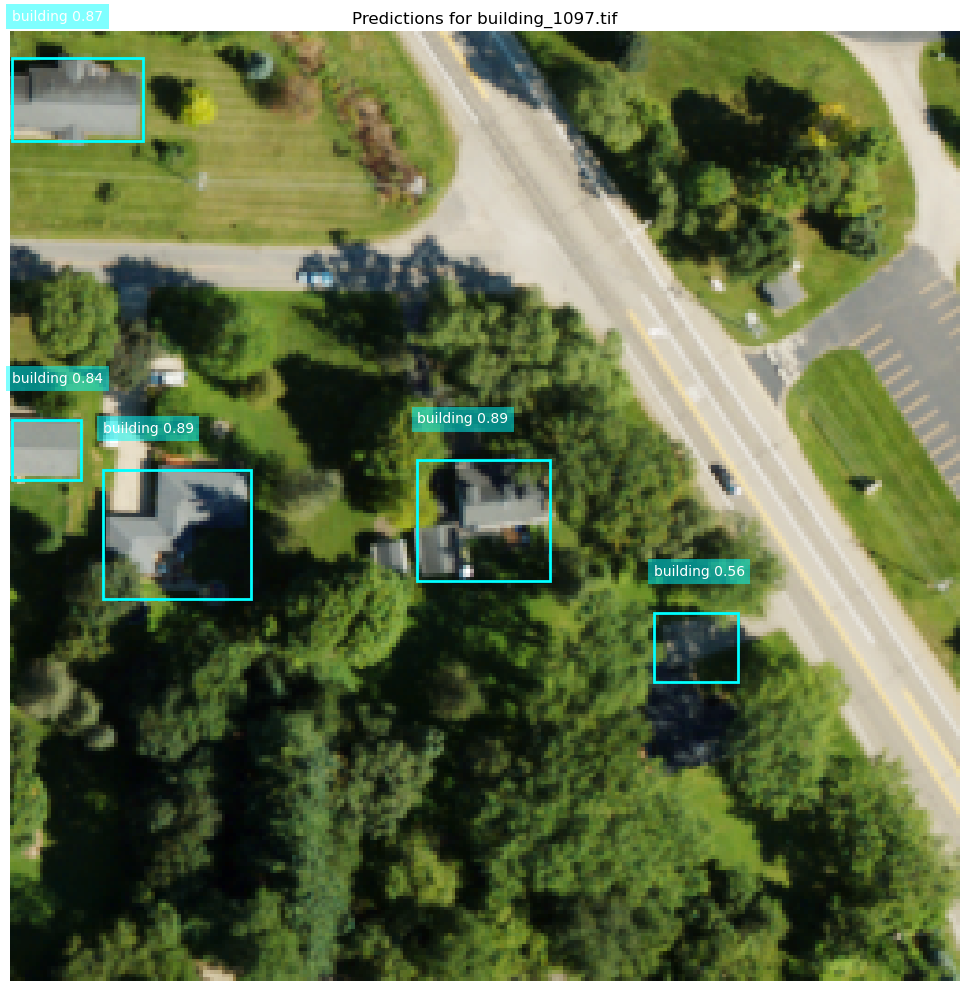

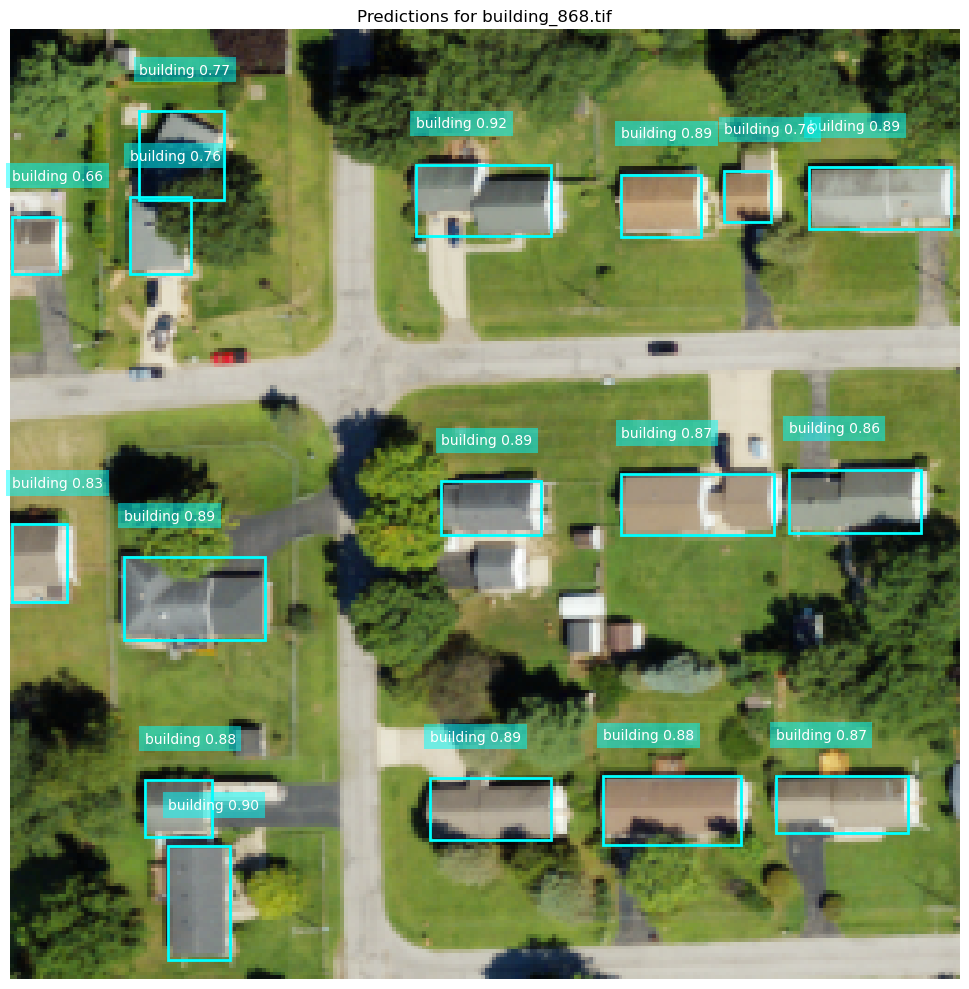

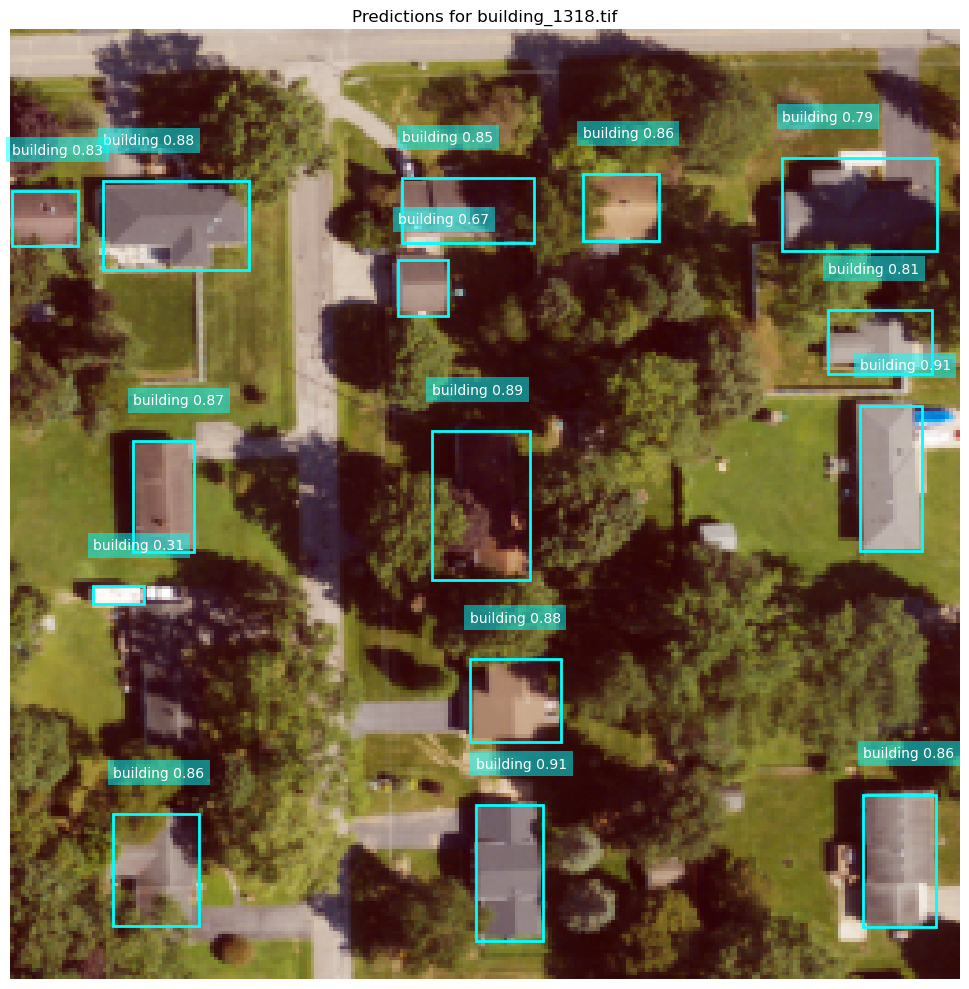

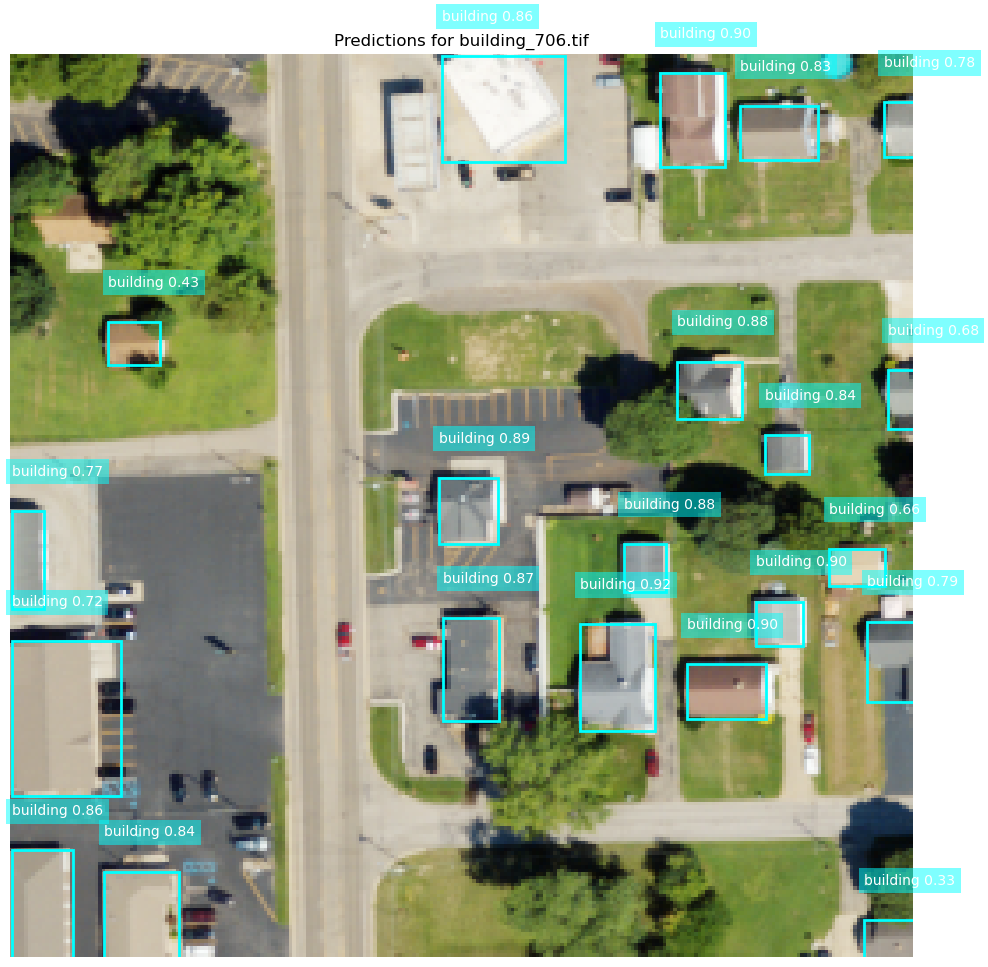

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO
import rasterio
import numpy as np

# Define paths (assuming these are available from previous cells)
dataset_base_dir = os.path.join(base_output, "dataset")
test_images_dir = os.path.join(dataset_base_dir, "test", "images")

# Load the best trained model (path from previous execution results)
model_path = r'C:\Users\Nitro 5\runs\detect\yolov8_buildings2\weights\best.pt'
model = YOLO(model_path)

# Get a list of all image files in the test set
image_files = [f for f in os.listdir(test_images_dir) if f.endswith('.tif')]

# Select a few random images to visualize
num_visualizations = 5 # Adjust as needed
sample_images = random.sample(image_files, min(num_visualizations, len(image_files)))

print(f"Visualizing {len(sample_images)} random images from the test set...")

for img_filename in sample_images:
    img_fp = os.path.join(test_images_dir, img_filename)

    # Load image using rasterio
    with rasterio.open(img_fp) as src_img:
        image_data = src_img.read()

    # Normalize image data for better visualization
    normalized_image_data = np.zeros_like(image_data, dtype=float)
    for i in range(image_data.shape[0]):
        band = image_data[i, :, :]
        min_val = band.min()
        max_val = band.max()
        if max_val - min_val > 0:
            normalized_image_data[i, :, :] = (band - min_val) / (max_val - min_val)
        else:
            normalized_image_data[i, :, :] = 0

    # Run inference on the image
    results = model(img_fp, verbose=False) # verbose=False to suppress extensive output

    # Plot image and predictions
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Display image
    if normalized_image_data.shape[0] >= 3:
        ax.imshow(normalized_image_data[0:3, :, :].transpose(1, 2, 0))
    else:
        ax.imshow(normalized_image_data[0, :, :], cmap='gray')

    ax.set_title(f'Predictions for {img_filename}')
    ax.axis('off')

    # Draw bounding boxes
    for r in results:
        for *xyxy, conf, cls in r.boxes.data:
            # Convert tensor to numpy array and then to float
            x1, y1, x2, y2 = [float(v) for v in xyxy]
            confidence = float(conf)
            class_id = int(cls)

            # Create a Rectangle patch
            width = x2 - x1
            height = y2 - y1
            rect = patches.Rectangle((x1, y1), width, height,
                                     linewidth=2, edgecolor='cyan', facecolor='none')
            ax.add_patch(rect)

            # Add label and confidence
            label = f'{model.names[class_id]} {confidence:.2f}'
            ax.text(x1, y1 - 10, label, color='white', fontsize=10,
                    bbox=dict(facecolor='cyan', alpha=0.5, edgecolor='none'))

    plt.tight_layout()
    plt.show()

In [ ]:
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
import os

# 1. Configuration
MODEL_PATH = r'C:\Users\Nitro 5\runs\detect\yolov8_buildings2\weights\best.pt'
IMAGE_PATH = r"C:\Users\Nitro 5\Downloads\m_4009442_nw_15_060_20220710\m_4009442_nw_15_060_20220710.tif"

# 2. Load Model using the 'ultralytics' wrapper
detection_model = AutoDetectionModel.from_pretrained(
    model_type='ultralytics',
    model_path=MODEL_PATH,
    confidence_threshold=0.46,
    device='cpu'
)

# 3. Perform Full Sliced Inference
print("Processing large TIFF (this may take a few minutes)...")
result = get_sliced_prediction(
    IMAGE_PATH,
    detection_model,
    slice_height=256,
    slice_width=256,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2
)

# 4. Result Summary
total_buildings = len(result.object_prediction_list)
print("-" * 30)
print(f"Total Buildings Detected: {total_buildings}")

Processing large TIFF (this may take a few minutes)...
Performing prediction on 3100 slices.
------------------------------
Total Buildings Detected: 2704


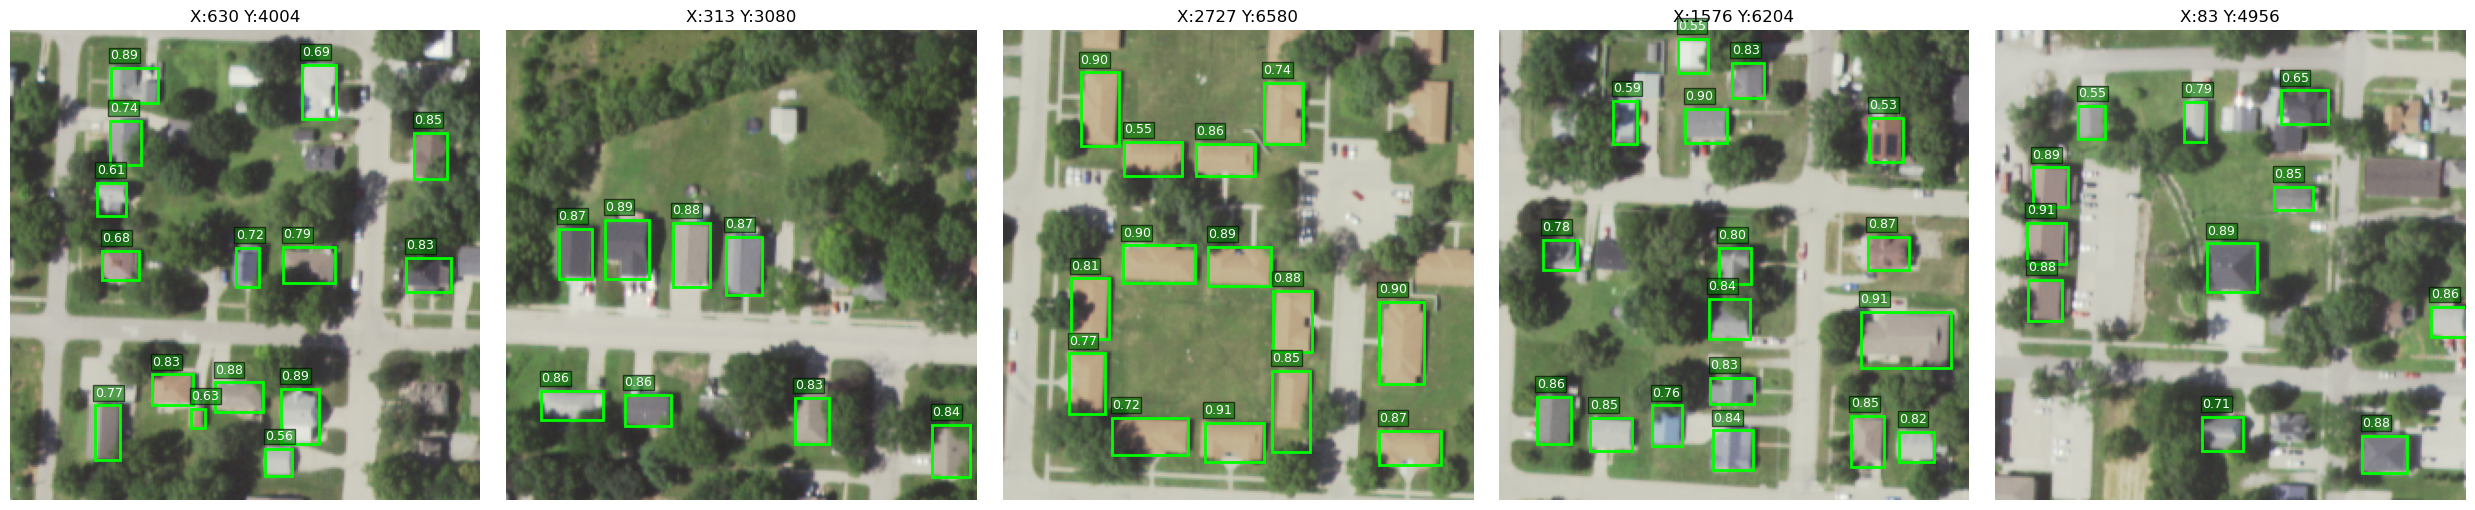

Individual patches saved to: D:\Building_Detection\Prediction\Samples
Full summary strip saved to: D:\Building_Detection\Prediction\verification_summary.png


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import rasterio
from rasterio.windows import Window
import numpy as np
import random
import os

# 1. Configuration for Export
SAMPLES_DIR = os.path.join(OUTPUT_DIR, "Samples")
os.makedirs(SAMPLES_DIR, exist_ok=True)
NUM_SAMPLES = 5

with rasterio.open(IMAGE_PATH) as src:
    # Set up the main summary figure
    fig, axes = plt.subplots(1, NUM_SAMPLES, figsize=(25, 5))

    # Pick random samples that contain at least one detection
    if len(result.object_prediction_list) >= NUM_SAMPLES:
        samples = random.sample(result.object_prediction_list, NUM_SAMPLES)
    else:
        samples = result.object_prediction_list

    for i, pred in enumerate(samples):
        # Define crop (256x256) centered on detection
        bbox = pred.bbox
        cx, cy = (bbox.minx + bbox.maxx) // 2, (bbox.miny + bbox.maxy) // 2
        win = Window(cx - 128, cy - 128, 256, 256)

        # Read and reorder tile
        tile = src.read([1, 2, 3], window=win, boundless=True, fill_value=0)
        tile = np.transpose(tile, (1, 2, 0))

        axes[i].imshow(tile)

        # Draw all detections in this specific window
        for p in result.object_prediction_list:
            pb = p.bbox
            if (pb.minx >= win.col_off and pb.maxx <= win.col_off + win.width and
                pb.miny >= win.row_off and pb.maxy <= win.row_off + win.height):

                lx, ly = pb.minx - win.col_off, pb.miny - win.row_off
                w, h = pb.maxx - pb.minx, pb.maxy - pb.miny

                # Add Box
                rect = patches.Rectangle((lx, ly), w, h, linewidth=2, edgecolor='#00FF00', facecolor='none')
                axes[i].add_patch(rect)

                # Add Confidence label
                axes[i].text(lx, ly - 5, f"{p.score.value:.2f}", color='white', fontsize=9,
                             bbox=dict(facecolor='green', alpha=0.6, pad=1))

        axes[i].set_title(f"X:{int(win.col_off)} Y:{int(win.row_off)}")
        axes[i].axis('off')

        # --- NEW: Save individual patch ---
        # We use a temporary figure to save just this one axis
        extent = axes[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(os.path.join(SAMPLES_DIR, f"patch_{i}.png"), bbox_inches=extent.padded(0.1))

    # Save the full summary strip
    summary_path = os.path.join(OUTPUT_DIR, "verification_summary.png")
    plt.tight_layout()
    plt.savefig(summary_path, dpi=150)
    plt.show()

print(f"Individual patches saved to: {SAMPLES_DIR}")
print(f"Full summary strip saved to: {summary_path}")

In [ ]:
import geopandas as gpd
from shapely.geometry import box
import os

OUTPUT_DIR = r"D:\Building_Detection\Prediction"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. Get Spatial Metadata
with rasterio.open(IMAGE_PATH) as src:
    tiff_transform = src.transform
    tiff_crs = src.crs

# 2. Transform Pixel BBoxes to Map Geometries
geometries = []
confidences = []

for pred in result.object_prediction_list:
    px_bbox = pred.bbox # minx, miny, maxx, maxy

    # Transform pixel corners to geographic coordinates
    # (Column, Row) -> (X, Y)
    ul = tiff_transform * (px_bbox.minx, px_bbox.miny)
    lr = tiff_transform * (px_bbox.maxx, px_bbox.maxy)

    # Create the geographic box (minx, miny, maxx, maxy)
    # Most projections have Y increasing upwards, so lower-right Y is 'miny'
    geo_poly = box(ul[0], lr[1], lr[0], ul[1])

    geometries.append(geo_poly)
    confidences.append(pred.score.value)

# 3. Save as GeoJSON
gdf = gpd.GeoDataFrame({
    'confidence': confidences,
    'class': 'building'
}, geometry=geometries, crs=tiff_crs)

output_path = os.path.join(OUTPUT_DIR, "building_footprints.geojson")
gdf.to_file(output_path, driver='GeoJSON')

print(f"Success! {len(gdf)} building footprints exported with accurate CRS to:")
print(output_path)

Success! 2704 building footprints exported with accurate CRS to:
D:\Building_Detection\Prediction\building_footprints.geojson
